# SBC for the CR model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import binom, norm
from scipy.integrate import solve_ivp, dblquad
import random

from bayesflow.networks import InvertibleNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.models import GenerativeModel

In [2]:
# ODE model for conversion reaction 
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)
   
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]])

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 3
time_points = np.linspace(0, 10, n_obs)
missing_max = 2

def batch_simulator_augment01(prior_samples, n_obs):
    """
    Simulate multiple conversion model datasets with missing values and augmentation by zeros/ones
    """   
    n_sim = prior_samples.shape[0]   # batch size 
    sim_data = np.ones((n_sim, n_obs, 2), dtype=np.float32)   # 1 batch consisting of n_sim datasets, each with n_obs observations
    n_missing = np.random.randint(0, missing_max+1, size=n_sim)
    
    for m in range(n_sim):
        theta = 10**prior_samples[m]
        s = theta[0] + theta[1]
        b = theta[0]/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        sim_data[m, :, 0] = sol + np.random.normal(0, sigma, size = n_obs)   # observable: y = x_2 + N(0,sigma²) 
        
        # artificially induce missing data
        missing_indices = random.sample(range(n_obs), n_missing[m])
        sim_data[m][missing_indices] = np.array([-1.0, 0.0])  
        
    return sim_data

We build an amortized parameter estimation network.

In [3]:
bf_meta = {
    'n_coupling_layers': 5,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

## Generate test data sets

In [4]:
n_sbc = 5000
n_post_samples_sbc = 250
params_sbc = prior(n_sbc)
x_augment01 = batch_simulator_augment01(params_sbc, n_obs)

## Sample from BayesFlow using the different encodings

In [5]:
%%time

# Augment by 0/1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_augment01 = amortizer.sample(x_augment01, n_post_samples_sbc)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_augment01_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
Wall time: 42.1 s


In [7]:
%%time

# Insert -1
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

x_insert = np.ones((n_sbc, n_obs, 1), dtype=np.float32)
for m in range(n_sbc):
    x_insert[m, :, 0] = x_augment01[m, :, 0]
    
# BayesFlow samples from the learned posterior    
param_samples_insert = amortizer.sample(x_insert, n_post_samples_sbc)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_insert-1_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
Wall time: 41.1 s


In [13]:
%%time

# Time labels
summary_net = LSTM(8)
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_timelabels_5ACB_[64,64,64]_LSTM(8)_ckpts', skip_checks=True)

# BayesFlow samples from the learned posterior
param_samples_time = np.empty((n_sbc, n_post_samples_sbc, 2), dtype=np.float32)
for m in range(n_sbc):
    x = x_augment01[m, :, 1]
    present_indices = np.where(x == 1.)[0]
    x_time = np.empty((1, len(present_indices), 2), dtype=np.float32)
    x_time[0, :, 0] = x_augment01[m, present_indices, 0]
    x_time[0, :, 1] = time_points[present_indices]
    param_samples_time[m] = amortizer.sample(x_time, n_post_samples_sbc)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_timelabels_5ACB_[64,64,64]_LSTM(8)_ckpts\ckpt-300
Wall time: 6min 40s


## Plotting method

In [19]:
def plot_sbc(axarr, theta_samples, theta_test, param_names, bins=25, interval=0.99):
    """ Plots the simulation-based posterior checking histograms as advocated by Talts et al. (2018). """

    # Plot settings
    N = int(theta_test.shape[0])

    # Compute ranks (using broadcasting)    
    ranks = np.sum(theta_samples < theta_test[:, np.newaxis, :], axis=1)
    
    # Compute interval
    endpoints = binom.interval(interval, N, 1 / bins)

    # Plot histograms
    for j in range(len(param_names)):
        
        # Add interval
        axarr[j].axhspan(endpoints[0], endpoints[1], facecolor='gray', alpha=0.3)
        axarr[j].axhline(np.mean(endpoints), color='gray', zorder=0, alpha=0.5)
        
        sns.histplot(ranks[:, j], kde=False, ax=axarr[j], color='#a34f4f', bins=bins, alpha=0.95)
        
        axarr[j].set_title(param_names[j])
        axarr[j].spines['right'].set_visible(False)
        axarr[j].spines['top'].set_visible(False)
        if j == len(param_names) - 1:
            axarr[j].set_xlabel('Rank statistic')
        axarr[j].get_yaxis().set_ticks([])
        axarr[j].set_ylabel('')

## SBC histograms

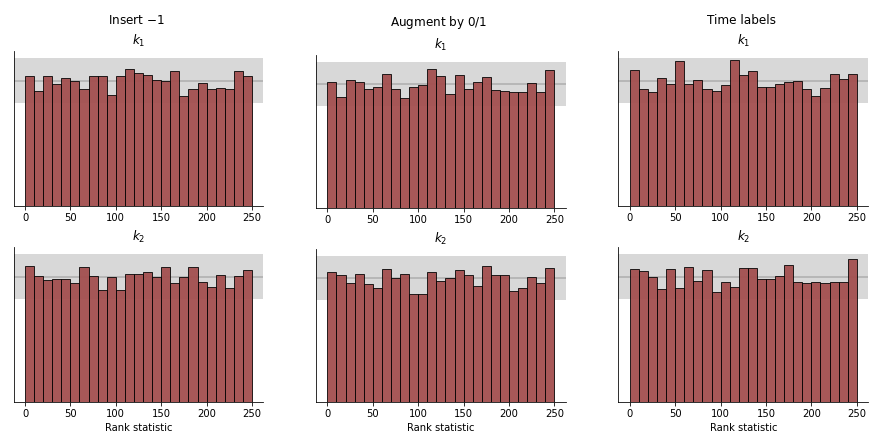

In [20]:
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
subfigs = fig.subfigures(nrows=1, ncols=3, wspace=0.15)
all_axes = [subfig.subplots(nrows=2, ncols=1, gridspec_kw={'wspace': 0}) for subfig in subfigs.ravel()]

for ix, (samples, label) in enumerate([
    (param_samples_insert, "Insert $-1$"),
    (param_samples_augment01, "Augment by $0/1$"),
    (param_samples_time, "Time labels")
]):
    axes = all_axes[ix].flat
    plot_sbc(axes, samples, params_sbc, ["$k_1$", "$k_2$"])
    subfigs[ix].suptitle(label)
    if ix > 0:
        for ax in axes:
            ax.set_ylabel(None)
plt.suptitle(" ", fontsize=0.1)

for fmt in ["png", "pdf"]:
    fig.savefig(f"figures/CR3_sbc.{fmt}", dpi=300, bbox_inches='tight')